In [43]:
import wandb

from tqdm import tqdm
from lit_diffusion.diffusion_base.constants import LOGGING_TRAIN_PREFIX, LOGGING_VAL_PREFIX

In [16]:
api = wandb.Api(timeout=15)

In [17]:
runs = api.runs("ssl-diffusion/rs-ddpm-ms-classification")

## Declare Constants ##

In [62]:
MINIMUM_AGGREGATION = "min"
MAXIMUM_AGGREGATION = "max"

CLASSIFICATION_METRICS = [ "accuracy","precision", "recall", "f1" ]

## Get Runs ##

In [ ]:
ewc_classification_ids=["o1tldx99", "5th69f6u", "4pavkimp", "8sgvkhxz", "mlmr0rw1", "jh8d6lwr", "rjl8mbla"]
run_results = {}
for run in [r for r in runs if r.id in ewc_classification_ids]:
    single_run_complete_history = []
    # Get all data
    for x in tqdm(run.scan_history(), desc="Loading history"):
        single_run_complete_history.append(x)
    run_results[run.id] = {
        "id": run.id, 
        "name": run.name,
        "history": single_run_complete_history,
    }

Loading history: 82520it [02:13, 616.81it/s]
Loading history: 82520it [01:56, 710.82it/s]
Loading history: 82520it [01:57, 700.93it/s]
Loading history: 82520it [01:46, 772.31it/s]
Loading history: 12001it [00:15, 896.95it/s]

### Modality Comparison ###

In [44]:
import pandas as pd
import seaborn as sns

In [45]:
from enum import Enum

class Resolution(Enum):
    EPOCH = "_epoch"
    STEP = "_step"

In [86]:
from typing import Dict, Union, Tuple, List, Callable

def convert_run_histories_to_df(metrics: List[str], aggregations: List[Union[str, Callable]], split_prefixes: str, resolution: Resolution, runs: Dict[str, Union[str, Dict[str, float]]]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Configure relevant metrics which are relevant
    keys_of_interest = [
        f"{prefix}{k}{resolution.value}" 
        for k in metrics.keys()
        for prefix in split_prefixes
    ]
    print(keys_of_interest)
    # Initialize dictionary to create pd.DataFrame from
    data = {
        k: []
        for k in ["id"] + ["name"] + ["epoch"] + keys_of_interest 
    }
    # Iterate over run_histories to format metrics
    for _, run in run_results.items():
        run_history = run["history"]
        n = 0
        for k in keys_of_interest:
            append_values = [metrics_dict[k] for metrics_dict in run_history if metrics_dict[k]]
            n = len(append_values)
            data[k] += append_values
        data["epoch"] += [i for i in range(n)]
        data["name"] += [run["name"] for _ in range(n)]
        data["id"] += [run["id"] for _ in range(n)]
                                                                                                                                   
    visualization_df = pd.DataFrame(data)                                                                                                                                      
    return visualization_df, visualization_df.groupby("id").agg({k: aggregations for k in keys_of_interest})

In [88]:
df, agg_df = convert_run_histories_to_df(
    metrics=CLASSIFICATION_METRIC_AGGREGATIONS,
    split_prefixes=[LOGGING_TRAIN_PREFIX],
    resolution=Resolution.STEP,
    aggregations=["min", "max"],
    runs={"5th69f6u": run_results["5th69f6u"]},
)

['train/accuracy_step', 'train/precision_step', 'train/recall_step', 'train/f1_step']


In [89]:
df

,id,name,epoch,train/accuracy_step,train/precision_step,train/recall_step,train/f1_step
0,5th69f6u,s2_era5-ewc-classification,0,0.041667,0.041667,0.041667,0.041667
1,5th69f6u,s2_era5-ewc-classification,1,0.060606,0.060606,0.060606,0.060606
2,5th69f6u,s2_era5-ewc-classification,2,0.064394,0.064394,0.064394,0.064394
3,5th69f6u,s2_era5-ewc-classification,3,0.053030,0.053030,0.053030,0.053030
4,5th69f6u,s2_era5-ewc-classification,4,0.056818,0.056818,0.056818,0.056818
...,...,...,...,...,...,...,...
77632,4pavkimp,s2_s1-ewc-classification,38814,0.973485,0.973485,0.973485,0.973485
77633,4pavkimp,s2_s1-ewc-classification,38815,0.962121,0.962121,0.962121,0.962121
77634,4pavkimp,s2_s1-ewc-classification,38816,0.958333,0.958333,0.958333,0.958333
77635,4pavkimp,s2_s1-ewc-classification,38817,0.984848,0.984848,0.984848,0.984848


In [90]:
agg_df

train/accuracy_step           train/precision_step            \
                         min       max                  min       max   
id                                                                      
4pavkimp            0.026515  0.996212             0.026515  0.996212   
5th69f6u            0.041667  0.996212             0.041667  0.996212   

         train/recall_step           train/f1_step            
                       min       max           min       max  
id                                                            
4pavkimp          0.026515  0.996212      0.026515  0.996212  
5th69f6u          0.041667  0.996212      0.041667  0.996212

<Axes: xlabel='epoch', ylabel='train/f1_step'>

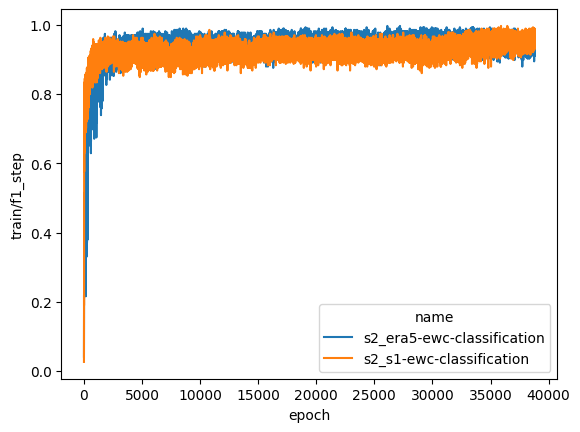

In [92]:
sns.lineplot(data=df, x="epoch", y="train/f1_step", hue="name")

<Axes: xlabel='epoch', ylabel='train/f1_epoch'>

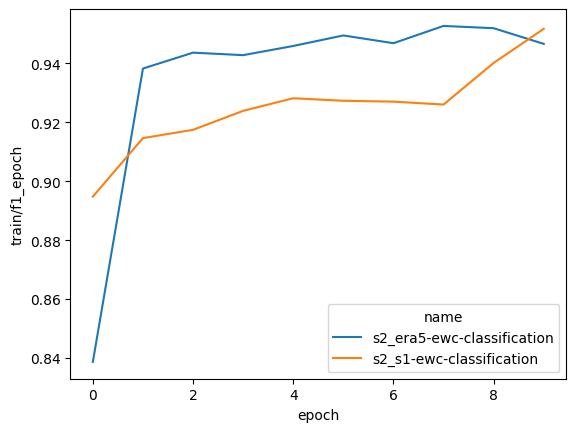

In [25]:
sns.lineplot(data=df, x="epoch", y="train/f1_epoch", hue="name")

### SSL Approach vs. Supervised Baseline ###

In [ ]:
len(run_results["kkygq9ye"]["history"].iter_rows())